# Baseline DataSet Creation and Stadium Start Point
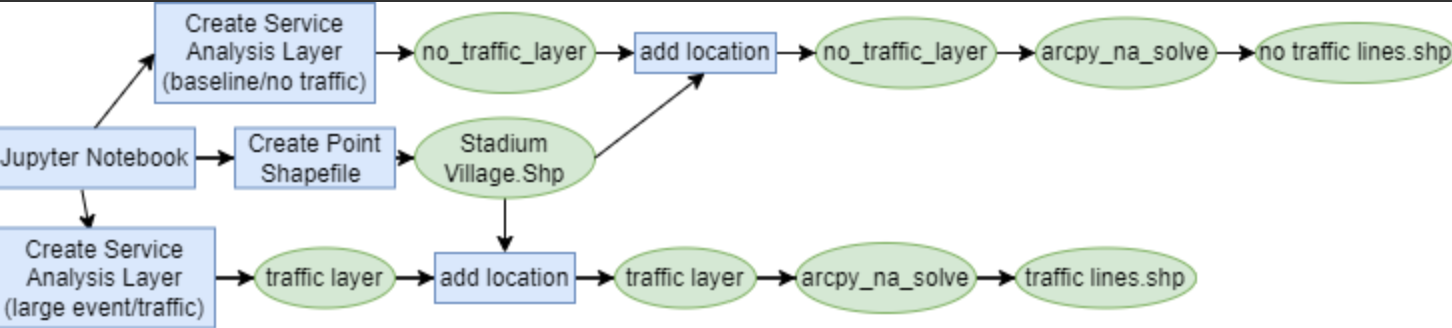

Credits: chat.openai.com and draw.io

## Imports

In [1]:
import os
os.environ['LC_ALL'] = 'en_US.UTF-8'
os.environ['LANG'] = 'en_US.UTF-8'
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
#location to current directory
file_path = os.path.dirname(arcpy.mp.ArcGISProject('CURRENT').filePath) + '\\final_files'
os.chdir(file_path)
arcpy.env.workspace = file_path
print(arcpy.env.workspace)

C:\Users\Track\OneDrive\Documents\ArcGIS\Projects\ArcIIFinalTransitProject\final_files


## Create Stadium Village Shape

In [2]:
#overview: creates stadium village point and baseline traffic dataset
#define the location we want to travel to/from given the events.
#coordinate intersection of Oak St and Washington Ave (longitude, latitude)
facility_coords = (-93.2265955, 44.9754918)
#name of the new shapefile
shapefile_name = "Stadium_Village.shp"
#spatial reference (can be an EPSG code, a full path to a PRJ file, or an arcpy.SpatialReference object)
#example: WGS 1984
spatial_ref = arcpy.SpatialReference(4326)
#create the point shapefile
dest_point = arcpy.CreateFeatureclass_management(arcpy.env.workspace, shapefile_name, "POINT", spatial_reference=spatial_ref)
#create a new insert cursor for adding features to the shapefile
with arcpy.da.InsertCursor(shapefile_name, ["SHAPE@XY"]) as cursor:
    #add the facility point
    cursor.insertRow([facility_coords])

## Create Service Area Layer for Baseline

In [3]:
#make 2 Service Area Analysis Layers
#analysis layer 1: No Traffic Baseline (Wednesday, July 12, 2023 at 3:00am)
#output: Traffic analysis layer lines
no_traffic_layer = arcpy.na.MakeServiceAreaAnalysisLayer(
    network_data_source="https://www.arcgis.com/",
    layer_name="No Traffic Baseline",
    travel_mode="Driving Time",
    travel_direction="TO_FACILITIES",
    cutoffs=[10],
    time_of_day="7/12/2023 3:00:00 AM",
    time_zone="LOCAL_TIME_AT_LOCATIONS",
    output_type="LINES",
    polygon_detail="STANDARD",
    geometry_at_overlaps="OVERLAP",
    geometry_at_cutoffs="RINGS",
    polygon_trim_distance="100 Meters",
    exclude_sources_from_polygon_generation=None,
    accumulate_attributes=None,
    ignore_invalid_locations="SKIP"
)

#adding destination location to the layer
arcpy.na.AddLocations(
    in_network_analysis_layer=no_traffic_layer,
    sub_layer="Facilities",
    in_table=dest_point,
    field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
    search_tolerance="20000 Meters",
    sort_field=None,
    search_criteria="main.Routing_Streets SHAPE",
    match_type="MATCH_TO_CLOSEST",
    append="APPEND",
    snap_to_position_along_network="NO_SNAP",
    snap_offset="5 Meters",
    exclude_restricted_elements="EXCLUDE",
    search_query=None,
    allow_auto_relocate="ALLOW"
)

<Result 'No Traffic Baseline'>

## Create Service Area Layer for Large Event

In [4]:
#analysis layer 2: Traffic event (Ex. October 27, 2023 7:45pm; Gopher Hockey VS Badgers)
event_time = "10/27/2023 7:45:00 PM"
name_event = "Large Event"

traffic_layer = arcpy.na.MakeServiceAreaAnalysisLayer(
    network_data_source="https://www.arcgis.com/",
    layer_name=name_event,
    travel_mode="Driving Time",
    travel_direction="TO_FACILITIES",
    cutoffs=[10],
    time_of_day=event_time,
    time_zone="LOCAL_TIME_AT_LOCATIONS",
    output_type="LINES",
    polygon_detail="STANDARD",
    geometry_at_overlaps="OVERLAP",
    geometry_at_cutoffs="RINGS",
    polygon_trim_distance="100 Meters",
    exclude_sources_from_polygon_generation=None,
    accumulate_attributes=None,
    ignore_invalid_locations="SKIP"
)

#adding destination location to the layer
arcpy.na.AddLocations(
    in_network_analysis_layer=traffic_layer,
    sub_layer="Facilities",
    in_table=dest_point,
    field_mappings="Name # #;CurbApproach # 0;Attr_Minutes # 0;Attr_TravelTime # 0;Attr_Miles # 0;Attr_Kilometers # 0;Attr_TimeAt1KPH # 0;Attr_WalkTime # 0;Attr_TruckMinutes # 0;Attr_TruckTravelTime # 0;Breaks_Minutes # #;Breaks_TravelTime # #;Breaks_Miles # #;Breaks_Kilometers # #;Breaks_TimeAt1KPH # #;Breaks_WalkTime # #;Breaks_TruckMinutes # #;Breaks_TruckTravelTime # #",
    search_tolerance="20000 Meters",
    sort_field=None,
    search_criteria="main.Routing_Streets SHAPE",
    match_type="MATCH_TO_CLOSEST",
    append="APPEND",
    snap_to_position_along_network="NO_SNAP",
    snap_offset="5 Meters",
    exclude_restricted_elements="EXCLUDE",
    search_query=None,
    allow_auto_relocate="ALLOW"
)

<Result 'Large Event'>

## Solving Network Analysis

In [5]:
#solve the network dataset
##THIS COSTS ESRI CREDITS
solved_no_traffic = arcpy.na.Solve(no_traffic_layer)
#solve the network dataset
##THIS COSTS ESRI CREDITS
solved_traffic = arcpy.na.Solve(traffic_layer)

## Pulls Lines from Network Analysis Layer

In [6]:
#extract the Service Area Polygons sublayer
no_traffic_sublayer = no_traffic_layer.getOutput(0)
no_traffic_sublayer = arcpy.na.GetNASublayer(no_traffic_sublayer, "SALines")

#export the service area polygons to a new shapefile
output_shapefile = "no_traffic_lines.shp"
arcpy.management.CopyFeatures(no_traffic_sublayer, output_shapefile)

#extract the Service Area Polygons sublayer
traffic_sublayer = no_traffic_layer.getOutput(0)
traffic_sublayer = arcpy.na.GetNASublayer(traffic_sublayer, "SALines")

#export the service area polygons to a new shapefile
output_shapefile = "traffic_lines.shp"
arcpy.management.CopyFeatures(traffic_sublayer, output_shapefile)

<Result 'C:\\Users\\Track\\OneDrive\\Documents\\ArcGIS\\Projects\\ArcIIFinalTransitProject\\final_files\\traffic_lines.shp'>

## Quality Assurance Quality Control

In [7]:
#ROAD NETWORK QAQC
baseline_dataset = no_traffic_sublayer
event_dataset = traffic_sublayer
#completeness/Logical Consistency.
#check if the baseline (no traffic) engulfs the event (traffic-filled) data. This ensures all the data can be compared between the two sets.
#get the minimum bounding geometries (extent) of each dataset
baseline_extent = arcpy.Describe(baseline_dataset).extent
event_extent = arcpy.Describe(event_dataset).extent
#check if baseline encompasses event data
encompasses = (baseline_extent.contains(event_extent))
if encompasses:
    print("Baseline extent is larger than traffic extent. Data is good.")
else:
    print("Baseline extent is smaller than traffic extent. Data is not good.")

Baseline extent is larger than traffic extent. Data is good.


In [8]:
#get the list of fields for each dataset
#use Describe to get dataset information
base_desc = arcpy.Describe(baseline_dataset)
event_desc = arcpy.Describe(event_dataset)
#list all field names from the dataset
base_field_names = [field.name for field in base_desc.fields]
event_field_names = [field.name for field in event_desc.fields]
#compare the fields
same_columns = set(base_field_names) == set(event_field_names)
print(f"Do both datasets have the same columns? {same_columns}")

Do both datasets have the same columns? True


In [10]:
def check_for_isolated_segments(input_dataset):
    #define the output dataset for the spatial join
    output_dataset = "..\\ArcIIFinalTransitProject.gdb\\temp_data"

    arcpy.analysis.SpatialJoin(
    target_features=input_dataset,
    join_features=input_dataset,
    out_feature_class=output_dataset,
    join_operation="JOIN_ONE_TO_MANY",
    join_type="KEEP_ALL",
    match_option="INTERSECT",
    search_radius=None,
    distance_field_name=""
    )
    
    #summarize the join count by the original feature's unique ID
    summary_table = arcpy.CreateUniqueName("JoinCountSummary.csv", arcpy.env.workspace)
    
    arcpy.analysis.Statistics(
    in_table=output_dataset,
    out_table=summary_table,
    statistics_fields="Join_Count SUM",
    case_field="TARGET_FID",
    concatenation_separator=""
    )
    #arcpy.Statistics_analysis(output_dataset, summary_table, [["Join_Count", "SUM"]], "TARGET_FID")
    #find features that have a SUM_JoinCount == 1, indicating no joins to other features
    isolated_segments = [row[0] for row in arcpy.da.SearchCursor(summary_table, ["TARGET_FID"], "SUM_Join_Count = 1")]
    
    #clean up temporary datasets
    arcpy.Delete_management(output_dataset)
    arcpy.Delete_management(summary_table)
    
    #return list of isolated segment IDs
    return isolated_segments
#check for isolated segments in both datasets
baseline_isolated_segments = check_for_isolated_segments(baseline_dataset)
event_isolated_segments = check_for_isolated_segments(event_dataset)
print("Baseline Dataset Isolated Segments:", baseline_isolated_segments)
print("Event Dataset Isolated Segments:", event_isolated_segments)

Baseline Dataset Isolated Segments: []
Event Dataset Isolated Segments: []


In [11]:
#checks missing values
def check_missing_values(dataset, fields):
    missing_values = {}
    for field in fields:
        with arcpy.da.SearchCursor(dataset, [field]) as cursor:
            for row in cursor:
                if row[0] is None:
                    if field not in missing_values:
                        missing_values[field] = 1
                    else:
                        missing_values[field] += 1
                        
    if not missing_values:
        return "No missing values found."
    else:
        return f"Missing values: {missing_values}"

fields_to_check = ["FromCumul_TravelTime", "FromCumul_Kilometers", "ToCumul_TravelTime", "ToCumul_Kilometers"]
#check for both datasets
print("No Traffic Baseline:", check_missing_values(baseline_dataset, fields_to_check))
print("Large Event:", check_missing_values(event_dataset, fields_to_check))

No Traffic Baseline: No missing values found.
Large Event: No missing values found.
